#### Import libraries and setup matplotlib

In [10]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from waveglow.denoiser import Denoiser

In [11]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [12]:
hparams = create_hparams()
hparams.sampling_rate = 22050

#### Load model from checkpoint

In [13]:
checkpoint_path = "ayachi_nene_2"
model = load_model(hparams)
if hparams.enable_cuda:
    model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
    _ = model.cuda().eval()#.half()
else:
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])
    _ = model.eval()#.half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [14]:
waveglow_path = 'waveglow_ayachi_nene'
if hparams.enable_cuda:
    waveglow = torch.load(waveglow_path)['model']
    waveglow.cuda().eval()#.half()
else:
    waveglow = torch.load(waveglow_path, map_location=torch.device('cpu'))['model']
    waveglow.eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

#### Prepare text input

In [15]:
text = "こんにちは。"
sequence = np.array(text_to_sequence(text, ['japanese_cleaners']))[None, :]
if hparams.enable_cuda:
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
else:
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).long()

#### Decode text input and plot results

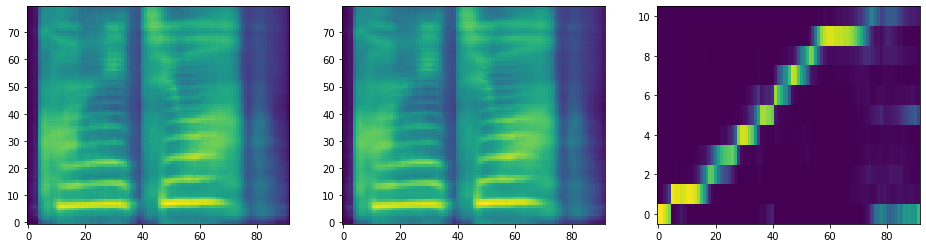

In [16]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [17]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### (Optional) Remove WaveGlow bias

In [18]:
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate) 